# Basic Exploratory Data Analysis
## Prerequisites
- Install Python 3



In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Feature File
df = pd.read_csv("../TeamSeasons.csv")

## Basic Seed Exploration

In [2]:
tourney_teams = df[df['Seed'].notna()]

In [3]:
round_num_map = {
    "Play In": 0,
    "First Round": 1,
    "Second Round": 2,
    "Sweet Sixteen": 3,
    "Elite Eight": 4,
    "Final Four": 5,
    "Championship": 6,
    "Champion": 7
}
tourney_teams["ExitRoundNum"] = tourney_teams["ExitRound"].map(round_num_map)


/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_20314/2435551509.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tourney_teams["ExitRoundNum"] = tourney_teams["ExitRound"].map(round_num_map)


In [4]:
(5 + 5 + 6 + 7) / 4

5.75

In [5]:
seed_exp_perf = {
    1: 5.75, # Two lose the final four, one lose in championship, one win the championship
    2: 4, # Make the Elite Eight
    3: 3, 4: 3, # Make the Sweet Sixteen
    5: 2, 6: 2, 7: 2, 8: 2, # Make the Second Round
    9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1 # Lose the First Round
}
seed_historical_perf = {}

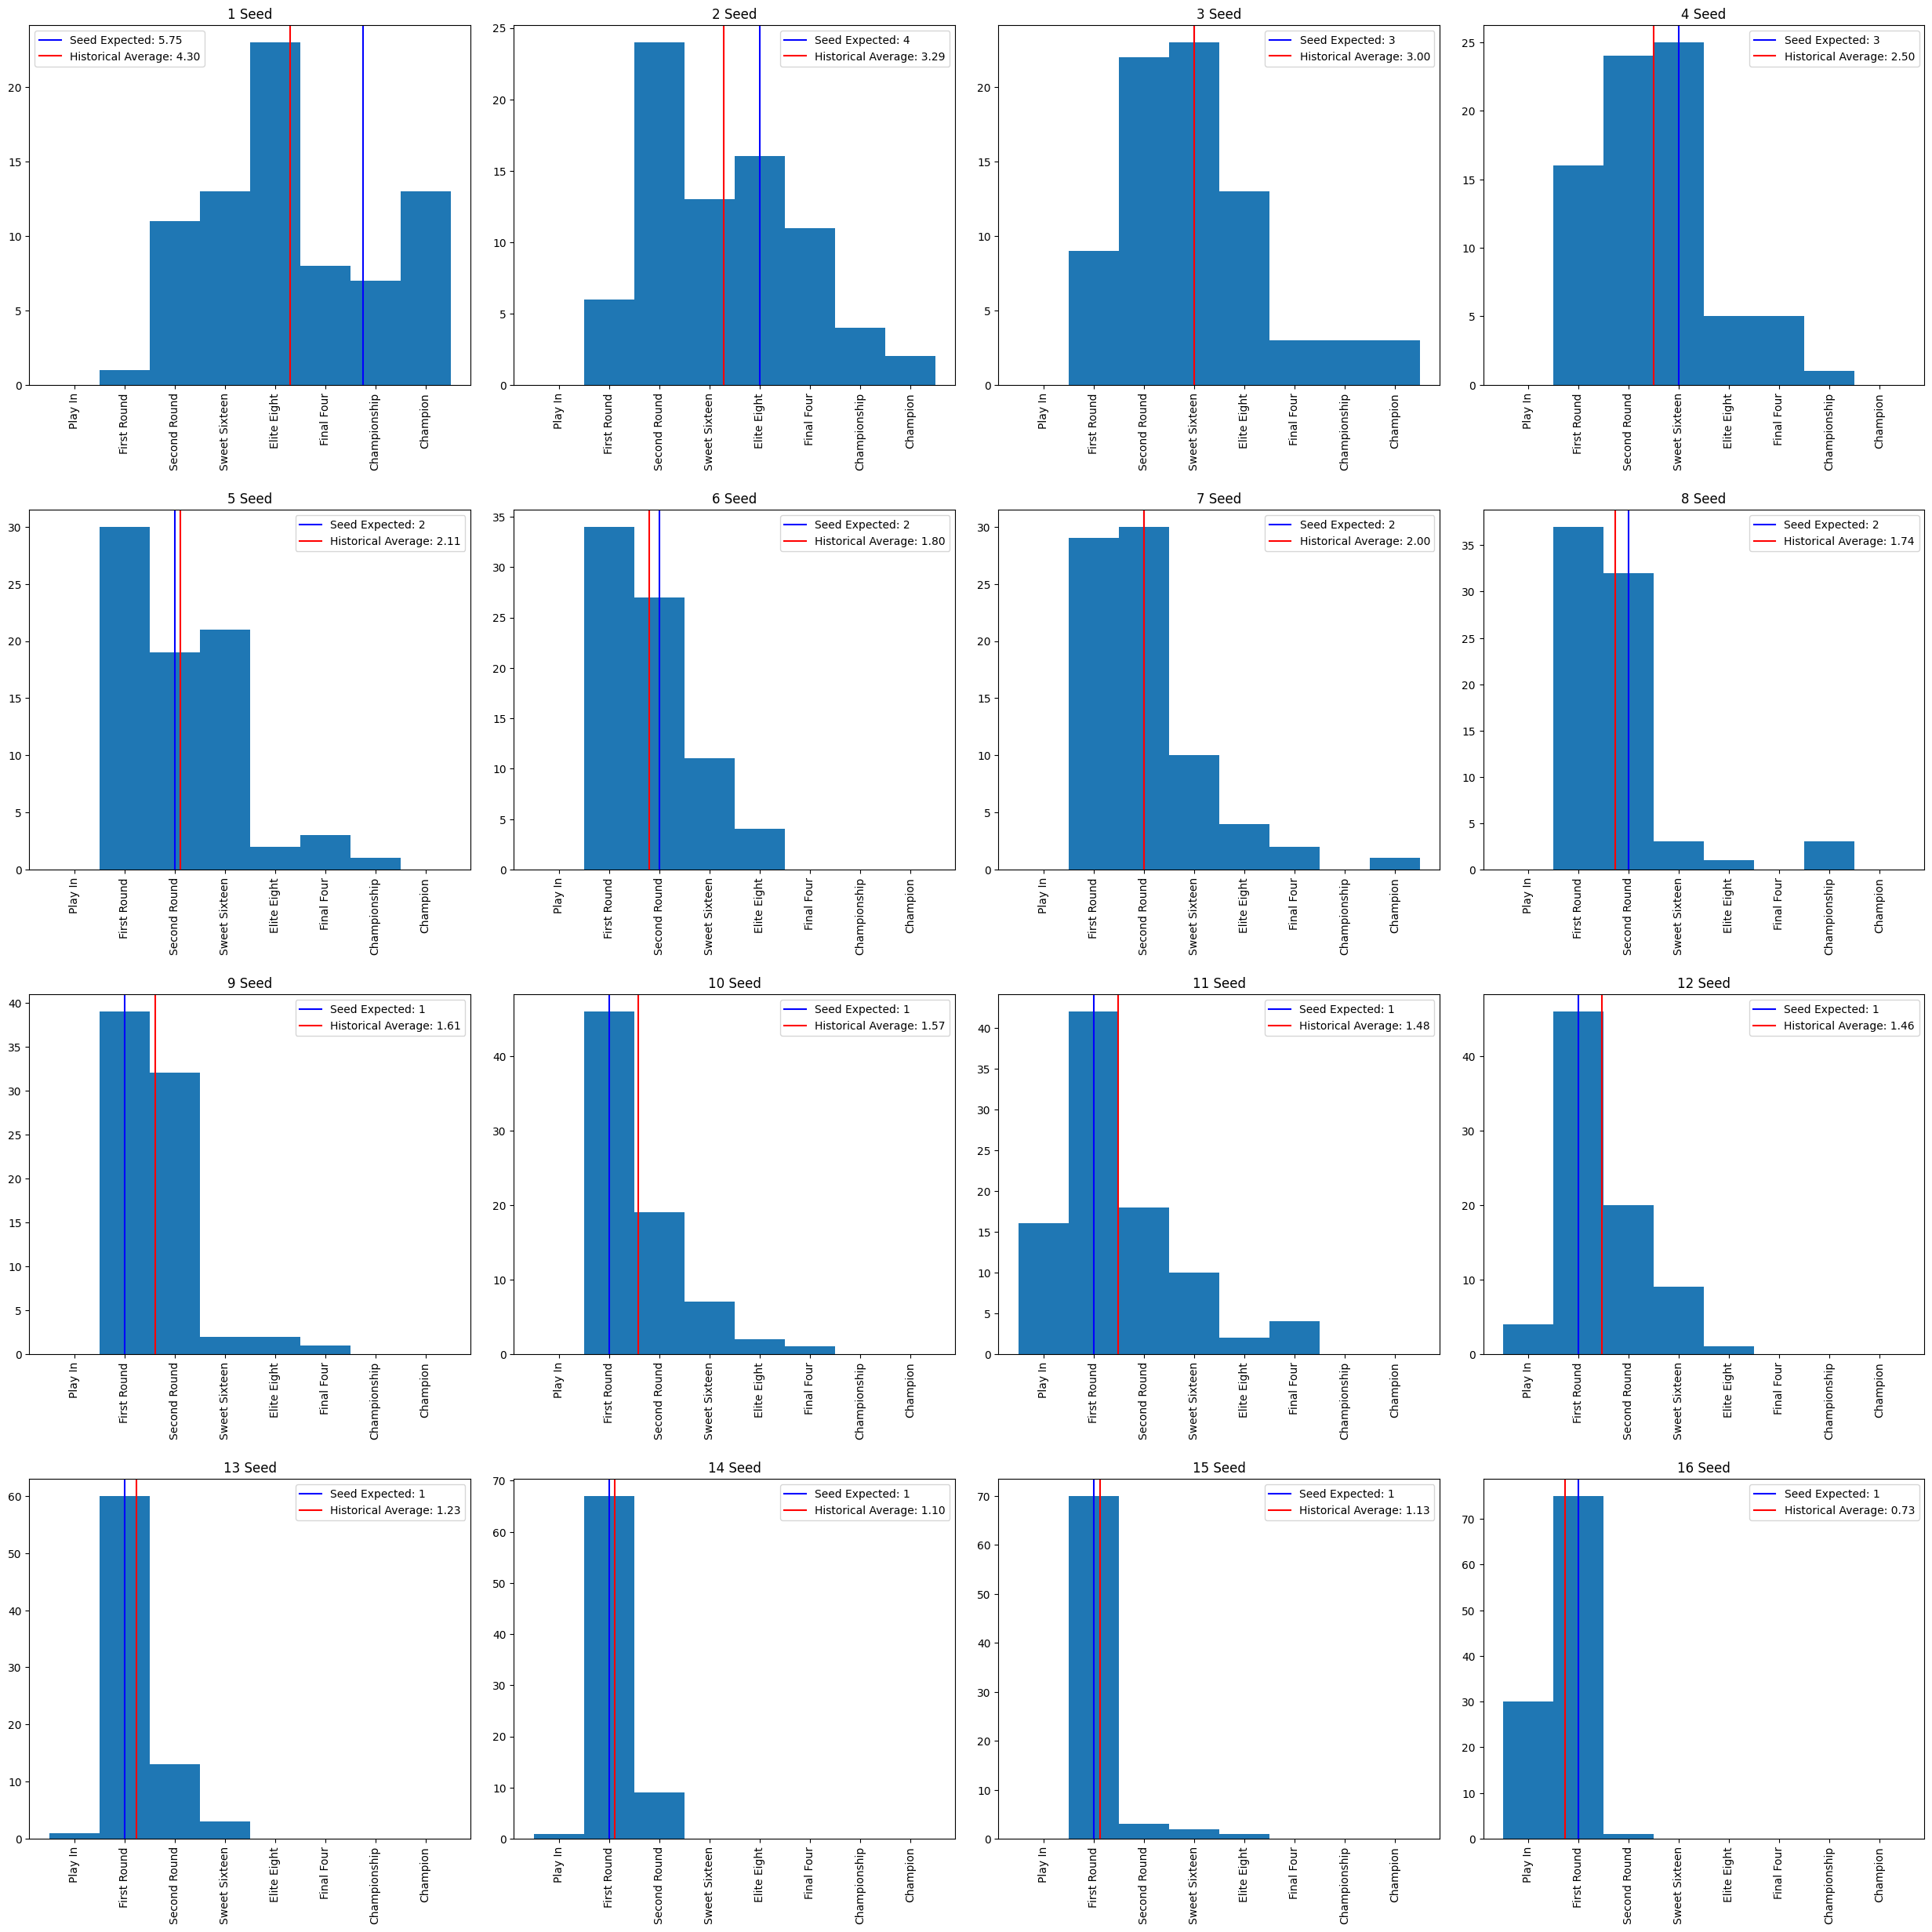

In [6]:
BIN_OFFSET = 0.5
fig, ax = plt.subplots(4, 4, figsize=(25, 25))
ax = ax.flatten()
for seed, seed_df in tourney_teams[["ExitRound", "Seed", "ExitRoundNum"]].groupby("Seed"):
    seed_axis = ax[int(seed) - 1]
    seed_df = seed_df.sort_values(["ExitRoundNum"])
    n, bins, patches = seed_axis.hist(seed_df["ExitRoundNum"], bins=range(0, 9))
    hist_avg = sum([count * rnd for count, rnd in zip(n, bins)]) / sum(n)
    seed_historical_perf[int(seed)] = hist_avg       
    seed_axis.set_title(f"{int(seed)} Seed")
    seed_axis.axvline(x = seed_exp_perf[int(seed)] + BIN_OFFSET, color = 'b', label = f'Seed Expected: {seed_exp_perf[int(seed)]}')
    seed_axis.axvline(x = hist_avg + BIN_OFFSET, color = 'r', label = f'Historical Average: {hist_avg:.2f}')
    seed_axis.set_xticks(ticks = [p._x0 + BIN_OFFSET for p in patches], labels = round_num_map.keys(), rotation=90)
    seed_axis.legend()
fig.tight_layout(pad = 2)
plt.show()

In [7]:
tourney_teams["ExceedExp"] = tourney_teams["ExitRoundNum"] > tourney_teams["Seed"].map(seed_exp_perf)

/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_20314/1454521417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tourney_teams["ExceedExp"] = tourney_teams["ExitRoundNum"] > tourney_teams["Seed"].map(seed_exp_perf)


/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_20314/4223504568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exceed_exp_df["color"] = exceed_exp_df["Seed"].apply(lambda x: cmap(norm(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


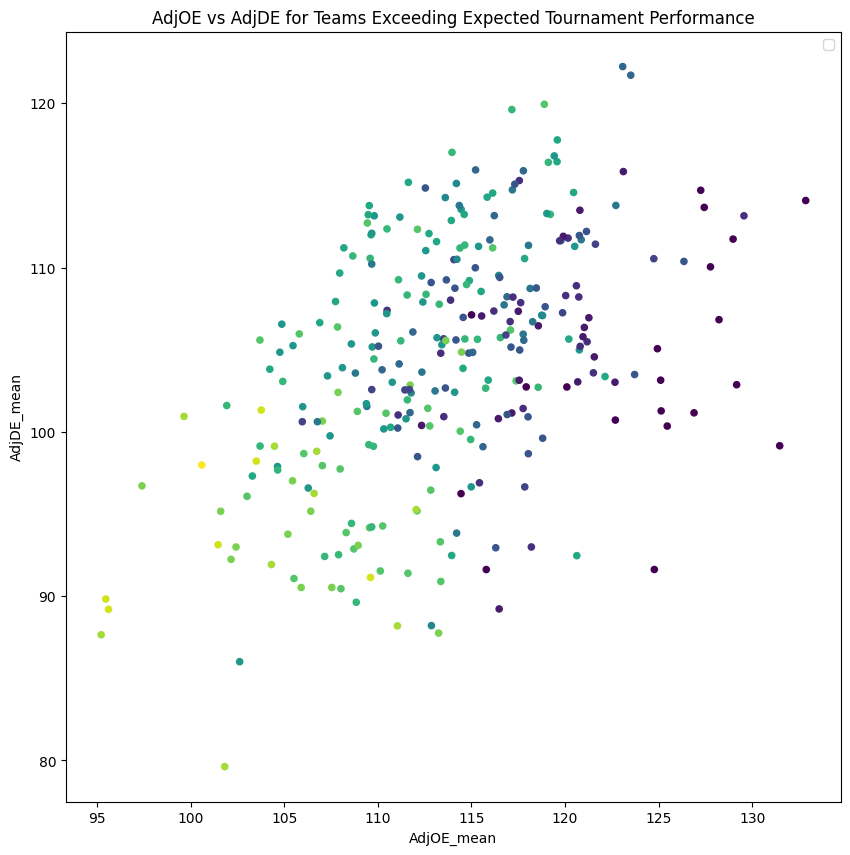

In [8]:
exceed_exp_df = tourney_teams[tourney_teams["ExceedExp"]]
# Color by seed
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(1, 16)
exceed_exp_df["color"] = exceed_exp_df["Seed"].apply(lambda x: cmap(norm(x)))
exceed_exp_df.plot(kind='scatter', x='AdjOE_mean', y='AdjDE_mean', c='color', figsize=(10, 10))
plt.title("AdjOE vs AdjDE for Teams Exceeding Expected Tournament Performance")
plt.legend()
plt.show()

# Train a basic logistic regression

In [9]:
print(tourney_teams.columns)

Index(['Points_mean', 'Poss_mean', 'OE_mean', 'DE_mean', 'NE_mean', 'FGM_mean',
       'FGA_mean', 'FGM3_mean', 'FGA3_mean', 'FTM_mean', 'FTA_mean', 'OR_mean',
       'DR_mean', 'Ast_mean', 'TO_mean', 'Stl_mean', 'Blk_mean', 'Fouls_mean',
       'FG%_mean', 'FG3%_mean', 'FT%_mean', 'OppPoints_mean', 'OppFGM_mean',
       'OppFGA_mean', 'OppFGM3_mean', 'OppFGA3_mean', 'OppFTM_mean',
       'OppFTA_mean', 'OppOR_mean', 'OppDR_mean', 'OppAst_mean', 'OppTO_mean',
       'OppStl_mean', 'OppBlk_mean', 'OppFouls_mean', 'OppFG%_mean',
       'OppFG3%_mean', 'OppFT%_mean', 'AdjOE_mean', 'AdjDE_mean', 'AdjNE_mean',
       'Points_stdev', 'Poss_stdev', 'OE_stdev', 'DE_stdev', 'NE_stdev',
       'FGM_stdev', 'FGA_stdev', 'FGM3_stdev', 'FGA3_stdev', 'FTM_stdev',
       'FTA_stdev', 'OR_stdev', 'DR_stdev', 'Ast_stdev', 'TO_stdev',
       'Stl_stdev', 'Blk_stdev', 'Fouls_stdev', 'FG%_stdev', 'FG3%_stdev',
       'FT%_stdev', 'OppPoints_stdev', 'OppFGM_stdev', 'OppFGA_stdev',
       'OppFGM3_stdev', '

In [10]:
tourney_teams["ExceedExp"].value_counts()

False    970
True     298
Name: ExceedExp, dtype: int64

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = tourney_teams[["AdjOE_mean", "AdjDE_mean", "AdjNE_mean", "Poss_mean", "FG3%_mean", "FT%_mean", "TO_mean", "Q1_WinPct", "Q2_WinPct", "Q3_WinPct", "Q4_WinPct", "Seed"]]
X.fillna(0, inplace=True)
Y = tourney_teams["ExceedExp"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size=0.25, random_state=0)
ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)



/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_20314/2167190023.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [19]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier

models = {
    "Logistic Reg": LogisticRegression(),
    "Ridge": RidgeClassifier(alpha=0.5),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel="poly", degree=3, C=0.1, gamma="auto"),
    "LinearSVC": LinearSVC(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier()
}
model_res = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall"])
for model_name, model in models.items():
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    model_res = model_res.append({
        "Model": model_name,
        "Accuracy": accuracy_score(predictions, Y_test),
        "Precision": precision_score(predictions, Y_test),
        "Recall": recall_score(predictions, Y_test)
    }, ignore_index=True)
print(model_res)


/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_20314/123421776.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_res = model_res.append({
/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_20314/123421776.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_res = model_res.append({
/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_20314/123421776.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

           Model  Accuracy  Precision    Recall
0   Logistic Reg  0.757098   0.000000  0.000000
1          Ridge  0.763407   0.000000  0.000000
2  Random Forest  0.744479   0.026667  0.200000
3            SVM  0.760252   0.000000  0.000000
4      LinearSVC  0.763407   0.000000  0.000000
5    Naive Bayes  0.526814   0.426667  0.230216
6            KNN  0.722397   0.133333  0.303030
7  Decision Tree  0.687697   0.373333  0.350000
8        XGBoost  0.716088   0.213333  0.340426


/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_20314/123421776.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_res = model_res.append({


# Naive Bayes Feature Importance

In [13]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(models["Naive Bayes"], X_test, Y_test)

for i in imps.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]:<8} {imps.importances_mean[i]:.3f} +/- {imps.importances_std[i]:.3f}")

TO_mean  0.008 +/- 0.007
Poss_mean 0.002 +/- 0.014
FG3%_mean 0.001 +/- 0.005
FT%_mean -0.003 +/- 0.002
AdjDE_mean -0.008 +/- 0.012
AdjNE_mean -0.009 +/- 0.006
Q4_WinPct -0.011 +/- 0.008
Q1_WinPct -0.028 +/- 0.006
Q2_WinPct -0.029 +/- 0.011
Seed     -0.038 +/- 0.013
AdjOE_mean -0.045 +/- 0.016
Q3_WinPct -0.052 +/- 0.009


['Seed', 0.17277816]
['Q3_WinPct', 0.086684465]
['FG3%_mean', 0.086441234]
['AdjDE_mean', 0.08141087]
['AdjOE_mean', 0.08077244]
['AdjNE_mean', 0.07906653]
['Q1_WinPct', 0.07635216]
['Q4_WinPct', 0.07301332]
['TO_mean', 0.06951839]
['Poss_mean', 0.06642124]
['Q2_WinPct', 0.064445175]
['FT%_mean', 0.06309599]


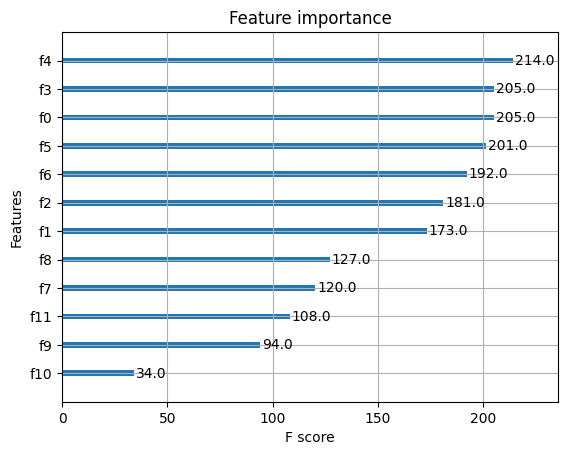

In [24]:
# XGBoost Feature Importance
sorted_idx = np.argsort(models["XGBoost"].feature_importances_)[::-1]
for index in sorted_idx:
    print([X.columns[index], models["XGBoost"].feature_importances_[index]]) 
from xgboost import plot_importance
plot_importance(models["XGBoost"])
plt.show()

# Predicting Exit Round

In [31]:
tourney_teams["ExitRoundNum"] = tourney_teams["ExitRound"].map(round_num_map)
tourney_teams["ExitRoundNum"].fillna(0, inplace=True)

In [43]:
# Predict ExitRoundNum with XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold

# Scale features per column
X = tourney_teams[["AdjOE_mean", "AdjDE_mean", "AdjNE_mean", "Poss_mean", "FG3%_mean", "FT%_mean", "TO_mean", "Q1_WinPct", "Q2_WinPct", "Q3_WinPct", "Q4_WinPct", "Seed"]]
X.fillna(0, inplace=True)
X = StandardScaler().fit_transform(X)
# Scale ExitRoundNum from 0 to 1
Y = tourney_teams["ExitRoundNum"]
Y = MinMaxScaler().fit_transform(Y.values.reshape(-1, 1))

xgb = XGBRegressor()
score = cross_val_score(xgb, X, Y, cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1))
print(f"MAE: {score.mean()} +/- {score.std()}")

/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_20314/3847528867.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


MAE: 0.26988579438611626 +/- 0.09559402397630637
